In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from adjustText import adjust_text

from PIL import Image
from pdb import set_trace as st 
import random
import json
import os 
from tqdm import tqdm
import string
from src.Aux import * 
from src.Triangles import Triangle
from src.Illustrate import * 
from src.text_in_bbox import *

In [2]:
emnist_loc = "/home/yfrid/Desktop/stem-whiteboard/dataset/mnist/EMNIST/raw/"
emnist_images = read_idx_ubyte(emnist_loc+"emnist-byclass-train-images-idx3-ubyte")
emnist_labels = read_idx_ubyte(emnist_loc+"emnist-byclass-train-labels-idx1-ubyte")
emnist_chars = string.digits+string.ascii_uppercase+string.ascii_lowercase
EMNIST = EMNIST_Handler(emnist_images,emnist_labels,emnist_chars)

Reading image data: 697932 images of 28x28 pixels.
Reading label data: 697932 labels.


In [9]:
lower_letters = string.ascii_lowercase
#greek_letters = ['α', 'β', 'γ', 'δ', 'θ']

def plot_geometry_improved(description):
    fig, ax = plt.subplots(figsize=(6,6),dpi = 64)
    labels = []
    handwritten = False#bool(random.getrandbits(1))
    # Set up the plot with some padding
    all_x = [v["x"] for v in description["vertices"]]
    all_y = [v["y"] for v in description["vertices"]]
    x_range = max(all_x) - min(all_x)
    y_range = max(all_y) - min(all_y)
    padding = max(x_range, y_range) * 0.1
    
    ax.set_xlim(min(all_x) - padding, max(all_x) + padding)
    ax.set_ylim(min(all_y) - padding, max(all_y) + padding)

####################################################### SEGMENTS
    description["index_lookup"] = {d["mark"]: i for i, d in enumerate(description["vertices"])} ## add index to each vertice for easier search
    description,segment_labels = plot_segments(description,ax,EMNIST,handwritten)
################################################### SPECIALS
    description = plot_specials(description,ax,EMNIST,handwritten)

################################################### ANGLES
    description, angle_labels = plot_angles(description,ax,EMNIST,handwritten)

    
#################################################### VERTICES    
    labels = plot_vertices(description,ax,EMNIST,handwritten)

    for v in description["vertices"]:
        v["x"] = np.around((v["x"]-min(all_x))/(max(all_x)-min(all_x)),2)
        v["y"] = np.around((v["y"]-min(all_y))/(max(all_y)-min(all_y)),2)
        

#################################################### QUESTION



##############################################################    
    # Combine all labels for adjustment
    all_labels = labels + segment_labels + angle_labels
    
    # Get all non-text artists (points, lines) to avoid
    avoid_objects = [artist for artist in ax.get_children() 
                    if not isinstance(artist, plt.Text)]
    
    # Fine-tune the label positioning
    adjust_text(all_labels, ax=ax,
                add_objects=avoid_objects,
                expand_points=(1.5, 1.5),    # Distance from points
                expand_text=(1.2, 1.2),     # Distance between labels
                expand_objects=(1.2, 1.2),  # Distance from lines/objects
                arrowprops=dict(arrowstyle='-', color='gray', alpha=0.5, lw=0.5),
                force_points=(0.5, 0.5),    # Force to avoid points
                force_text=(0.5, 0.5),      # Force to avoid text overlap
                force_objects=(0.3, 0.3),   # Force to avoid other objects
                lim=1000)                   # Maximum iterations
    
    ax.set_aspect('equal')
    ax.axis('off')

    plt.tight_layout()

    xs,ys = find_bbox(ax)
    buf = BytesIO()
    ax.figure.savefig(buf, format='png', bbox_inches='tight', dpi=64)
    plt.close(fig)
    buf.seek(0)
    img = Image.open(buf)
    cut_img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    y_pad_size,x_pad_size= 384-cut_img_cv.shape[0], 384-cut_img_cv.shape[1]
    img_cv = np.ones([384,384,3],dtype = np.int8)*255
    if xs[0] == 10:
        left_pad = x_pad_size
    else:
        left_pad = 0
    if ys[0] == 10:
        top_pad = y_pad_size
    else:
        top_pad = 0
    img_cv[top_pad:top_pad+cut_img_cv.shape[0],left_pad:left_pad+cut_img_cv.shape[1]] = cut_img_cv
    xs,ys = find_bbox(ax)
    xs[1]+= x_pad_size
    ys[1]+= y_pad_size
    text = f"AB⊥BC, ADE~ABC, DE∥AB ,and {chr(8738)}BAC=90°. prove ACD≅ACE"
    tokens = tokenize_with_equations(text)
    bbox = (xs[0], ys[0], xs[1]-xs[0], ys[1]-ys[0])  # x, y, width, height
    print(xs)
    print(ys)
    #plt.plot([xs[0],xs[1]],[ys[1],ys[0]])
    if handwritten:
        img_text = EMNIST.text_mat(tokens,bbox[2])
        img_text = np.repeat(np.expand_dims(img_text,2),3,axis = 2)
        plt.imshow(img_cv,cmap='gray')
        plt.imshow(img_text,cmap='gray',extent=[bbox[0], 
        bbox[0] + bbox[2], bbox[1] + min(bbox[3],img_text.shape[0]), bbox[1]],
        vmin=0,
        vmax=1,
        alpha=1 # Transparency (0=invisible, 1=opaque)
    )
        plt.xlim(0,img_cv.shape[1])
        plt.ylim(img_cv.shape[0],0)
    else:
        img_text = render_wrapped_text(tokens,bbox[2], bbox[3])
        combined = overlay_text_on_image(img_cv, img_text, bbox)
        plt.imshow(combined)
    plt.axis('off')
    
    return description


def convert_numpy_types(obj):
    if isinstance(obj, np.bool_):
        return bool(obj)
    elif isinstance(obj, (np.int_, np.intc, np.intp, np.int8, np.int16, np.int32, np.int64)):
        return int(obj)
    elif isinstance(obj, (np.float_, np.float16, np.float32, np.float64)):
        return float(obj)
    elif isinstance(obj, dict):
        return {k: convert_numpy_types(v) for k, v in obj.items()}
    elif isinstance(obj, (list, tuple)):
        return [convert_numpy_types(v) for v in obj]
    else:
        return obj



[177, 373]
[10, 147]


{'vertices': [{'mark': 'A', 'x': 0.5, 'y': 0.0},
  {'mark': 'B', 'x': 1.0, 'y': 0.33},
  {'mark': 'C', 'x': 0.0, 'y': 1.0},
  {'mark': 'D', 'x': 0.25, 'y': 0.5},
  {'mark': 'E', 'x': 0.5, 'y': 0.67},
  {'mark': 'F', 'x': 0.73, 'y': 0.15}],
 'segments': [{'mark': 'AB', 'known': True, 'length': 6.0, 'unit': ['cm']},
  {'mark': 'AC', 'known': True, 'length': 'n', 'unit': ['cm']},
  {'mark': 'BC', 'known': True, 'length': 't', 'unit': ['cm']},
  {'mark': 'AD', 'known': False},
  {'mark': 'DE', 'known': False},
  {'mark': 'AE', 'known': False},
  {'mark': 'BE', 'known': False},
  {'mark': 'CE', 'known': True, 'length': 'a', 'unit': ['cm']},
  {'mark': 'BF', 'known': False},
  {'mark': 'CF', 'known': True, 'length': 'w', 'unit': ['cm']},
  {'mark': 'AF', 'known': False}],
 'angles': [{'mark': 'ABC', 'known': True, 'value': 60.0, 'unit': 'deg'},
  {'mark': 'BCA', 'known': False},
  {'mark': 'CAB', 'known': True, 'value': 90.0, 'unit': 'deg'},
  {'mark': 'ADE', 'known': True, 'value': 90.0, 'u

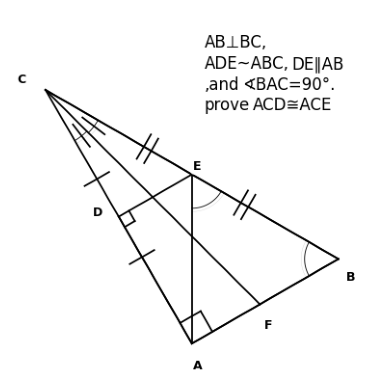

In [13]:
tri = Triangle(6,np.sqrt(3)*6,30)#rotation=np.random.randint(360),mirror=np.random.choice([True,False]))
tri.third_vertice("right")
A = tri.description["vertices"][0]["mark"]
B = tri.description["vertices"][1]["mark"]
C = tri.description["vertices"][2]["mark"]

#tri.add_median(A,B+C)
#tri.add_parallel(A+C,B,0.5)
tri.add_perpendicular(A+C,B)
tri.add_median(A,B+C)
tri.add_bisector(B+C+A)
#tri.add_bisector(C+A+B)
#tri.add_altitude(A,B+C)

tri.set_question()
tri.description["angles"][2]["known"] = True
tri.rotate()
plot_geometry_improved(tri.description)

In [11]:
tri.description

{'vertices': [{'mark': 'A', 'x': 0.5, 'y': 0.0},
  {'mark': 'B', 'x': 1.0, 'y': 0.33},
  {'mark': 'C', 'x': 0.0, 'y': 1.0},
  {'mark': 'D', 'x': 0.75, 'y': 0.17},
  {'mark': 'E', 'x': 0.5, 'y': 0.67},
  {'mark': 'F', 'x': 0.73, 'y': 0.15}],
 'segments': [{'mark': 'AB', 'known': False},
  {'mark': 'AC', 'known': False},
  {'mark': 'BC', 'known': True, 'length': 12.0, 'unit': ['cm']},
  {'mark': 'DE', 'known': True, 'length': 5.2, 'unit': ['cm']},
  {'mark': 'AE', 'known': True, 'length': 6.0, 'unit': ['cm']},
  {'mark': 'BE', 'known': True, 'length': 6.0, 'unit': ['cm']},
  {'mark': 'CE', 'known': True, 'length': 6.0, 'unit': ['cm']},
  {'mark': 'BF', 'known': True, 'length': 'r', 'unit': ['cm']},
  {'mark': 'CF', 'known': False},
  {'mark': 'AF', 'known': True, 'length': 2.78, 'unit': ['cm']}],
 'angles': [{'mark': 'ABC', 'known': False},
  {'mark': 'BCA', 'known': False},
  {'mark': 'CAB', 'known': True, 'value': 90.0, 'unit': 'deg'},
  {'mark': 'AEB', 'known': True, 'value': 60.0, 'u